In [1]:
import requests
import json
import os

# do_sleep()
import time
import random
def do_sleep():
    time.sleep(min(random.expovariate(0.1), 20.0))

def set_session_headers(session):
    session.headers = {
        'User-Agent': 'Instagram 200.0.0.18.255 (iPhone; iOS 16_0; en_US; en-US; scale=2.00; 750x1334) AppleWebKit/420+',
        'Accept-Language': 'en-US',
    }
    
def find_user_id(session, username):
    url = f'https://www.instagram.com/api/v1/users/web_profile_info/?username={username}'
    response = session.get(url)
    do_sleep()
    data = response.json()
    return data['data']['user']['id']
            
def post_data(session, user_id, path, count='', max_id='', temp=[]):
    url = f'https://www.instagram.com/api/v1/feed/user/{user_id}/?count={count}&max_id={max_id}'
    response = session.get(url)
    data = response.json()
    if 'items' not in data.keys():
        print(temp)
        print(data)
        return
    else:
        if not os.path.exists(path):
            os.makedirs(path)
        # 指定要儲存的檔案名稱
        file_name = f"{path}/{user_id}_{max_id}.json"
        # 將數據寫入 JSON 檔案
        with open(file_name, 'w', encoding='utf-8') as json_file:
            json.dump(data, json_file, ensure_ascii=False, indent=4)
        print(file_name)   
              
    if 'next_max_id' in data.keys():
        if data['next_max_id']:
            do_sleep()
            temp.append(data['next_max_id'])
            post_data(session, user_id, path, data['num_results'], data['next_max_id'], temp)
    else:
        return
    
if __name__ == "__main__":
    username = "username"
    path = './json'
    # create requests session
    session = requests.Session()
    # set session headers
    set_session_headers(session)
    
    # find user id
    user_id = find_user_id(session, username)
    # print(user_id)
    do_sleep()
    
    # load_post_date
    post_data(session, user_id, path)
    print('end')

end


In [2]:
from datetime import datetime
import re

import pandas as pd
import matplotlib.pyplot as plt

# 設定包含 JSON 檔案的目錄
json_files_directory = "./json/"
# 獲取目錄中的所有 JSON 檔案
json_files = [f for f in os.listdir(json_files_directory) if f.endswith('.json')]

# 讀取每個 JSON 檔案的內容並儲存到 df_list
df_list = []
for json_file in json_files:
    file_path = os.path.join(json_files_directory, json_file)

    with open(file_path, 'r', encoding='utf-8') as file:
        # 讀取JSON檔案內容
        json_data = json.load(file)
        
        # 這裡可以對讀取到的 JSON 數據進行操作
        for item in json_data['items']:
            if item['caption']!=None:
                media_id = item['caption']['media_id']
                post_time = datetime.fromtimestamp(int(item['caption']['created_at_utc']))
                text = item['caption']['text']
                hashtags = re.findall(r'#(\w+)', text)
            # 將數據添加到 DataFrame 的列表中
            df_list.append({'media_id': media_id, 'post_time': post_time, 'text': text, 'like_count': item['like_count'], 
                            'media_type': item['media_type'], 'hashtags': hashtags})
            
# 使用 pandas.concat 創建 DataFrame
df = pd.concat([pd.DataFrame(df_list)])

Q1 = df['like_count'].quantile(0.25)
Q3 = df['like_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['like_count'] >= lower_bound) & (df['like_count'] <= upper_bound)]
# print(df)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 150, 'random_state': 42, 'subsample': 0.9}
Mean Squared Error: 3542104285.2808814
R-squared: 0.7158790296293636
Mean Absolute Error: 45312.96342571719


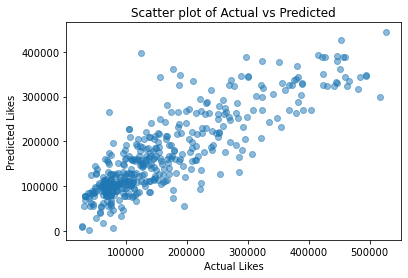

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

df_list = []
for data in df['hashtags']:
    hashtag_dict = {}
    for hashtag in data:
        hashtag_dict[hashtag] = 1
    df_list.append(hashtag_dict)

# 使用 pandas.concat 創建 DataFrame
df_hashtag = pd.concat([pd.DataFrame(df_list)])
# df_hashtag['day'] = df['post_time'].dt.day
df_hashtag['week'] = df['post_time'].dt.isocalendar().week
df_hashtag['month'] = df['post_time'].dt.month
df_hashtag['year'] = df['post_time'].dt.year
df_hashtag['hashtags_count'] = df['hashtags'].apply(len)

threshold_low = 5
threshold_up = 2000
# 統計每列的值
col_counts = df_hashtag.count()
# 根據閥值篩選列
# selected_columns = col_counts[col_counts >= threshold_low].index
selected_columns = col_counts[(threshold_up >= col_counts) & (col_counts >= threshold_low)].index
# 保留篩選後的列
df_hashtag = df_hashtag[selected_columns]
# 將 NaN 填為 0
df_hashtag = df_hashtag.fillna(0)
# print(df_hashtag)

# 分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(df_hashtag, df['like_count'], test_size=0.2, random_state=42)


model = GradientBoostingRegressor() 
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.2],
    'max_depth': [3],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'subsample': [0.9],
    'random_state': [42]
}
# 預測
# y_pred = model.predict(X_test)

# 使用 GridSearchCV 進行網格搜尋
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 輸出最佳參數
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳參數的 DecisionTreeRegressor 模型進行預測
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 評估模型性能
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# 畫出預測值和實際值的散布圖
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.show()